## Advanced calculations and analysis using probabilistic approaches and technical indicators
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

def calculate_technical_indicators(df, window=14):
   # Calculate rolling mean (SMA) for close price
    df['SMA'] = df['close'].rolling(window=window).mean()

    # Calculate rolling standard deviation for close price
    df['STD'] = df['close'].rolling(window=window).std()

    # Calculate Relative Strength Index (RSI)
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Calculate Exponential Moving Average (EMA)
    df['EMA'] = df['close'].ewm(span=window, adjust=False).mean()

    # Calculate Moving Average Convergence Divergence (MACD)
    df['MACD'] = df['EMA'] - df['EMA'].ewm(span=9, adjust=False).mean()

    # Calculate Bollinger Bands (Upper and Lower)
    df['Bollinger_Upper'] = df['SMA'] + (df['STD'] * 2)
    df['Bollinger_Lower'] = df['SMA'] - (df['STD'] * 2)

    # Calculate Average True Range (ATR)
    df['High-Low'] = df['high'] - df['low']
    df['High-Close'] = (df['high'] - df['close'].shift()).abs()
    df['Low-Close'] = (df['low'] - df['close'].shift()).abs()
    df['TR'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=window).mean()

    # Calculate On-Balance Volume (OBV)
    df['OBV'] = (df['volume'] * ((df['close'] > df['close'].shift()).astype(int) * 2 - 1)).cumsum()

    # Drop temporary columns used for calculations
    df.drop(columns=['High-Low', 'High-Close', 'Low-Close', 'TR'], inplace=True)
    
    return df

### Function explanation: 
#### Simple Moving Average (SMA)  
Calculates the average closing price over a given number of periods to smooth price data and identify trends.  

$$
\text{SMA} = \frac{\sum_{i=1}^{n} \text{Close Price}_i}{n}
$$  

---

#### Standard Deviation (STD)  
Measures the volatility of closing prices by calculating their dispersion from the mean.  

$$
\text{STD} = \sqrt{\frac{\sum_{i=1}^{n} (\text{Close Price}_i - \bar{\text{Close Price}})^2}{n}}
$$  

---

#### Relative Strength Index (RSI)  
Identifies overbought or oversold conditions by comparing the magnitude of recent gains and losses.  

$$
\text{RSI} = 100 - \frac{100}{1 + \frac{\text{Average Gain}}{\text{Average Loss}}}
$$  

---

#### Exponential Moving Average (EMA)  
Applies more weight to recent prices to track trends more effectively.  

$$
\text{EMA}_{\text{current}} = \left(\frac{2}{n+1}\right) \times (\text{Price}_{\text{current}} - \text{EMA}_{\text{previous}}) + \text{EMA}_{\text{previous}}
$$  

---

##### Moving Average Convergence Divergence (MACD)  
Calculates the difference between two EMAs to identify trend direction and momentum.  

$$
\text{MACD} = \text{EMA}_{\text{fast}} - \text{EMA}_{\text{slow}}
$$  

---

##### Bollinger Bands  
Creates an upper and lower band around the SMA to indicate price volatility.  

$$
\text{Upper Band} = \text{SMA} + 2 \times \text{STD}
$$  
$$
\text{Lower Band} = \text{SMA} - 2 \times \text{STD}
$$  

---

##### Average True Range (ATR)  
Measures market volatility based on the range between high, low, and the previous close prices.  

$$
\text{TR} = \max(\text{High} - \text{Low}, |\text{High} - \text{Previous Close}|, |\text{Low} - \text{Previous Close}|)
$$  
$$
\text{ATR} = \frac{\sum_{i=1}^{n} \text{TR}_i}{n}
$$  

---

##### On-Balance Volume (OBV)  
Tracks buying and selling pressure using volume changes based on price movements.  

$$
\text{OBV}_{\text{current}} = 
\begin{cases} 
\text{Previous OBV} + \text{Volume}, & \text{if Close > Previous Close} \\
\text{Previous OBV} - \text{Volume}, & \text{if Close < Previous Close} \\
\text{Previous OBV}, & \text{if Close = Previous Close}
\end{cases}
$$  


In [2]:
VNINDEX_indicators_df = pd.read_csv('price\VNINDEX.csv') 
calculate_technical_indicators(VNINDEX_indicators_df).head(1)

<>:1: SyntaxWarning: invalid escape sequence '\V'
<>:1: SyntaxWarning: invalid escape sequence '\V'
C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_69956\209883548.py:1: SyntaxWarning: invalid escape sequence '\V'
  VNINDEX_indicators_df = pd.read_csv('price\VNINDEX.csv')


,time,open,high,low,close,volume,SMA,STD,RSI,EMA,MACD,Bollinger_Upper,Bollinger_Lower,ATR,OBV
0,2024-09-04 09:00:00,1273.86,1273.86,1268.53,1271.34,76561000,NaN,NaN,NaN,1271.34,0.0,NaN,NaN,NaN,-76561000


In [3]:
# Define features columns (technical indicators)
features = ['SMA', 'STD', 'RSI', 'EMA', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower', 'ATR', 'OBV']


### Naive Bayes Classifier for Price Change Prediction

This function trains and evaluates a **Naive Bayes classifier** to predict stock price changes (`up`, `down`, `stable`) based on a set of technical indicators. It uses **Bayes' Theorem** to calculate the probability of price movements given the input features.

---

### Function Overview  

#### Parameters:
- **`df`**: A pandas DataFrame containing stock data with technical indicators.  
- **`features`**: A list of column names used as input features for the model (e.g., SMA, RSI, EMA).  
- **`target`**: The column name for the target variable (default: `'price_change'`).  
- **`test_size`**: Fraction of the data to be used as the test set (default: 30%).  
- **`random_state`**: Random state to ensure reproducibility (default: `42`).  

#### Returns:
- **`gnb`**: The trained Gaussian Naive Bayes model.  
- **`results`**: A dictionary containing the following evaluation metrics:
  - **Accuracy**: Proportion of correct predictions.  
  - **Classification Report**: Precision, recall, and F1-score for each class.  
  - **Confusion Matrix**: A matrix showing the actual vs predicted classifications.  

---

### Key Concepts  

#### Price Change Classification  
The target variable, `price_change`, is calculated based on the difference between consecutive closing prices:  

$$
\text{Price Change} =  
\begin{cases} 
\text{'up'}, & \text{if Close}_{t} - \text{Close}_{t-1} > 0 \\  
\text{'down'}, & \text{if Close}_{t} - \text{Close}_{t-1} < 0 \\  
\text{'stable'}, & \text{if Close}_{t} - \text{Close}_{t-1} = 0  
\end{cases}  
$$  

---

#### Bayes' Theorem  
The model relies on **Bayes' Theorem**, assuming all features are independent:  

$$
P(C \mid X) = \frac{P(X \mid C) \cdot P(C)}{P(X)}
$$  

Where:  
- \( P(C \mid X) \): Probability of a class (e.g., `up`) given the feature set \( X \).  
- \( P(X \mid C) \): Likelihood of observing \( X \) given class \( C \).  
- \( P(C) \): Prior probability of class \( C \).  
- \( P(X) \): Evidence or total probability of \( X \).  

---

### Steps in the Function  

1. **Target Variable Creation**  
   The function calculates a `price_change` column in the DataFrame using the formula above.  

2. **Data Preprocessing**  
   - Drops missing values.  
   - Splits the data into features (`X`) and target (`Y`).  
   - Further splits data into training and testing sets using `train_test_split`.  

3. **Training the Model**  
   - Uses `GaussianNB` from `sklearn.naive_bayes` to train the model on the training data.  

4. **Model Evaluation**  
   - Predictions are made on the test set.  
   - The following metrics are computed:
     - **Accuracy**: Overall correctness of predictions.  
     - **Classification Report**: Precision, recall, and F1-score for each class.  
     - **Confusion Matrix**: Compares actual and predicted labels.  

---



In [4]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_and_evaluate_naive_bayes(df, features, target='price_change', test_size=0.3, random_state=42):
    """
    Train and evaluate a Naive Bayes classifier for price change prediction.

    Parameters:
    - df (DataFrame): DataFrame containing the data with technical indicators and price columns.
    - features (list): List of column names to use as features.
    - target (str): Column name of the target variable (default is 'price_change').
    - test_size (float): Proportion of the data to use for testing (default is 0.3).
    - random_state (int): Random state for reproducibility (default is 42).

    Returns:
    - gnb (GaussianNB): Trained Gaussian Naive Bayes model.
    - results (dict): Dictionary containing accuracy, classification report, and confusion matrix.
    """
    # Add price change classification column
    df[target] = df['close'].diff().apply(
        lambda x: 'up' if x > 0 else ('down' if x < 0 else 'stable')
    )

    # Drop NaN values and reset index
    df.dropna(inplace=True)

    # Split the data into features (X) and target (Y)
    X = df[features]
    Y = df[target]

    # Split into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    # Create and train the Naive Bayes model
    gnb = GaussianNB()
    gnb.fit(X_train, Y_train)

    # Make predictions on the test set
    Y_pred = gnb.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(Y_test, Y_pred)
    report = classification_report(Y_test, Y_pred)
    matrix = confusion_matrix(Y_test, Y_pred)

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", matrix)

    # Store results in a dictionary
    results = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": matrix
    }

    return gnb, results

gnb, results = train_and_evaluate_naive_bayes(VNINDEX_indicators_df, features)


Accuracy: 0.5735294117647058

Classification Report:
               precision    recall  f1-score   support

        down       0.57      0.92      0.70        74
      stable       0.00      0.00      0.00         1
          up       0.62      0.16      0.26        61

    accuracy                           0.57       136
   macro avg       0.40      0.36      0.32       136
weighted avg       0.59      0.57      0.50       136


Confusion Matrix:
 [[68  0  6]
 [ 1  0  0]
 [51  0 10]]


d:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Recall (Sensitivity)
Recall measures the proportion of actual positives correctly identified by the model.

#### Formula:
$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{TP} + \text{False Negatives (FN)}}
$$

- **High recall** means fewer positive cases are missed.
- Important when missing positives is costly (e.g., fraud detection, medical diagnosis).

---

### F1-Score
The F1-Score is the harmonic mean of **Precision** and **Recall**, balancing both metrics.

#### Formula:
$$
\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

- **High F1-Score** indicates a good balance between precision and recall.
- Useful when both false positives and false negatives matter.

---

### Example Results

| **Class** | **Precision** | **Recall** | **F1-Score** |
|-----------|---------------|------------|--------------|
| **down**  | 0.57          | 0.92       | 0.70         |
| **stable**| 0.00          | 0.00       | 0.00         |
| **up**    | 0.62          | 0.16       | 0.26         |

- **Recall** for 'down' is high (0.92), meaning the model catches most price-downs.
- **Recall** for 'up' is low (0.16), meaning the model misses most price-ups.
- **F1-Score** reflects this imbalance, with 'up' having a low score.


In [5]:
# Đọc dữ liệu từ tệp CSV
vnindex_prices_df = pd.read_csv('price/VNINDEX.csv')
vn30_prices_df = pd.read_csv('price/VN30.csv')
hnxindex_prices_df = pd.read_csv('price/HNXINDEX.csv')

# Bỏ cột volume
vnindex_prices_df.drop(columns=['volume'], inplace=True)
vn30_prices_df.drop(columns=['volume'], inplace=True)
hnxindex_prices_df.drop(columns=['volume'], inplace=True)

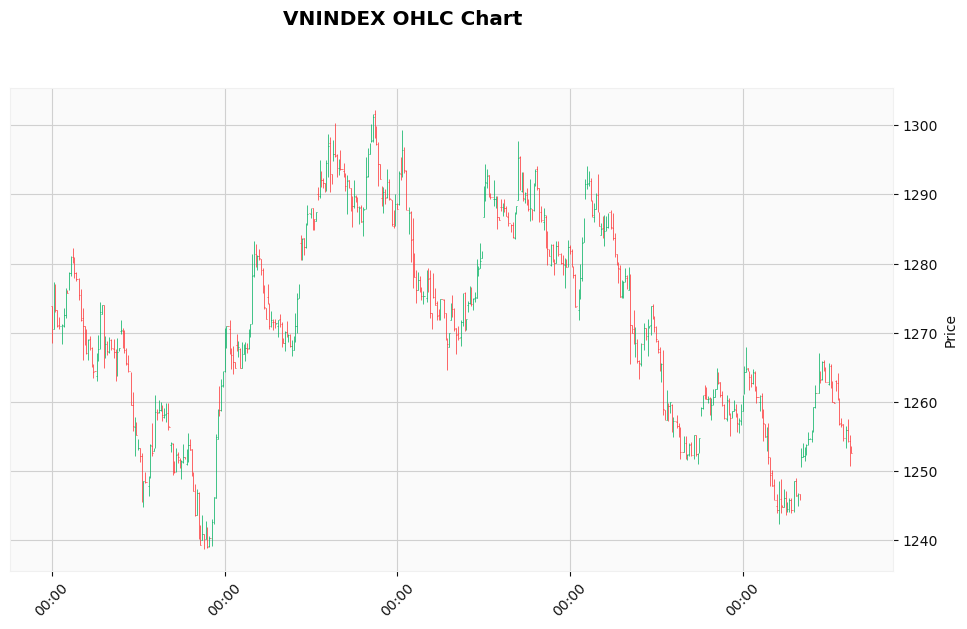

In [6]:
import mplfinance as mpf

# Convert the 'time' column to datetime format and set it as the index
vnindex_prices_df.index = pd.to_datetime(vnindex_prices_df.index)

# Plot the OHLC chart with adjusted size
mpf.plot(vnindex_prices_df, type='ohlc', title='VNINDEX OHLC Chart', style='yahoo', figratio=(16, 9), figscale=1.2)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_and_evaluate_logistic_regression(df, features, target='price_change', test_size=0.3, random_state=42):
    """
    Train and evaluate a Logistic Regression classifier for price change prediction based on volume.

    Parameters:
    - df (DataFrame): DataFrame containing the data with technical indicators and price columns.
    - features (list): List of column names to use as features.
    - target (str): Column name of the target variable (default is 'price_change').
    - test_size (float): Proportion of the data to use for testing (default is 0.3).
    - random_state (int): Random state for reproducibility (default is 42).

    Returns:
    - log_reg (LogisticRegression): Trained Logistic Regression model.
    - results (dict): Dictionary containing accuracy, classification report, and confusion matrix.
    """
    # Add price change classification column
    df[target] = df['close'].diff().apply(
        lambda x: 'up' if x > 0 else ('down' if x < 0 else 'stable')
    )

    # Drop NaN values and reset index
    df.dropna(inplace=True)

    # Split the data into features (X) and target (Y)
    X = df[features]
    Y = df[target]

    # Split into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    # Create and train the Logistic Regression model
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, Y_train)

    # Make predictions on the test set
    Y_pred = log_reg.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(Y_test, Y_pred)
    report = classification_report(Y_test, Y_pred)
    matrix = confusion_matrix(Y_test, Y_pred)

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", matrix)

    # Store results in a dictionary
    results = {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": matrix
    }

    return log_reg, results

# Define volume as the feature
volume_features = ['volume']

# Train and evaluate the Logistic Regression model
log_reg_volume, log_reg_volume_results = train_and_evaluate_logistic_regression(VNINDEX_indicators_df, volume_features)

Accuracy: 0.5367647058823529

Classification Report:
               precision    recall  f1-score   support

        down       0.54      1.00      0.70        73
      stable       0.00      0.00      0.00         2
          up       0.00      0.00      0.00        61

    accuracy                           0.54       136
   macro avg       0.18      0.33      0.23       136
weighted avg       0.29      0.54      0.37       136


Confusion Matrix:
 [[73  0  0]
 [ 2  0  0]
 [61  0  0]]


d:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Để nhận xét về confusion matrix mà bạn vừa tạo ra cho Logistic Regression, chúng ta cần xem xét các giá trị TP, TN, FP, và FN. Dưới đây là confusion matrix của Logistic Regression:

| Actual \ Predicted | down | stable | up |
|--------------------|------|--------|----|
| down               | 73   | 0      | 0  |
| stable             | 2    | 0      | 0  |
| up                 | 61   | 0      | 0  |

Trong đó:
- **TP (True Positive) = 73**: Có 73 mẫu thực sự là down và được dự đoán là down.
- **TN (True Negative) = 0**: Không có mẫu nào thực sự là stable hoặc up và được dự đoán đúng.
- **FP (False Positive) = 63**: Có 63 mẫu thực sự là stable hoặc up nhưng được dự đoán là down.
- **FN (False Negative) = 2**: Có 2 mẫu thực sự là stable nhưng được dự đoán là down.

### Nhận xét:
1. **Accuracy**:
   \[
   \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} = \frac{73 + 0}{73 + 0 + 63 + 2} = \frac{73}{138} \approx 0.53
   \]
   Mô hình có độ chính xác là 53%, tức là mô hình dự đoán đúng 53% các trường hợp.

2. **Precision**:
   \[
   \text{Precision} = \frac{TP}{TP + FP} = \frac{73}{73 + 63} = \frac{73}{136} \approx 0.54
   \]
   Precision là 54%, tức là trong số các dự đoán down, 54% là đúng.

3. **Recall**:
   \[
   \text{Recall} = \frac{TP}{TP + FN} = \frac{73}{73 + 2} = \frac{73}{75} \approx 0.97
   \]
   Recall là 97%, tức là trong số các mẫu thực sự là down, mô hình dự đoán đúng 97%.

4. **F1 Score**:
   \[
   \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \times \frac{0.54 \times 0.97}{0.54 + 0.97} \approx 0.69
   \]
   F1 Score là 69%, là trung bình điều hòa của Precision và Recall.

### Kết luận:
- Mô hình của bạn có độ chính xác trung bình (53%).
- Precision trung bình (54%) cho thấy mô hình có một số lượng đáng kể các dự đoán sai.
- Recall cao (97%) cho thấy mô hình rất tốt trong việc nhận diện các mẫu down.
- F1 Score (69%) cho thấy sự cân bằng giữa Precision và Recall.

Nếu bạn cung cấp các giá trị cụ thể cho confusion matrix của bạn, tôi có thể đưa ra nhận xét chi tiết hơn.
